# The Spark Context

In [1]:
from pyspark import SparkContext

In [2]:
sc = SparkContext('local[4]')

# RDD - Resilient Distributed Dataset

In [3]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [4]:
type(sc.parallelize(range(10)))

pyspark.rdd.PipelinedRDD

In [5]:
sc.parallelize(range(10)).collect()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [6]:
(sc.parallelize(range(10))
   .map(lambda x: x**2)
   .collect())

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [7]:
(sc.parallelize(range(10))
   .map(lambda x: x**2)
   .reduce(lambda x, y: x + y))

285

In [8]:
(sc.parallelize(range(10))
   .map(lambda x: (x % 2, x**2))
   .collect())

[(0, 0),
 (1, 1),
 (0, 4),
 (1, 9),
 (0, 16),
 (1, 25),
 (0, 36),
 (1, 49),
 (0, 64),
 (1, 81)]

In [9]:
(sc.parallelize(range(10))
   .map(lambda x: (x % 2, x**2))
   .reduceByKey(lambda x, y: x + y)
   .collect())

[(0, 120), (1, 165)]

# Reading Data

In [10]:
import zipfile

In [11]:
trips = sc.parallelize(zipfile
                       .ZipFile('/Users/dirk/Downloads/trips-2017.5.1-2017.5.31.csv.zip')
                       .open('trips-2017.5.1-2017.5.31.csv'))

In [12]:
trips.take(5)

[b'Start station,Start time,End station,End time\n',
 b'191,2017-05-01 02:29:23 +0200,210,2017-05-01 02:34:16 +0200\n',
 b'238,2017-05-01 06:00:07 +0200,175,2017-05-01 06:06:22 +0200\n',
 b'272,2017-05-01 06:00:18 +0200,219,2017-05-01 06:15:00 +0200\n',
 b'271,2017-05-01 06:01:17 +0200,163,2017-05-01 06:09:31 +0200\n']

# DataFrames

In [13]:
import pyspark.sql as psql
import datetime as dt
import calendar

In [14]:
def to_row(line):
    start_station, start_time, end_station, end_time = line.decode().split(',')
    try:
        start_datetime = dt.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S %z')
        return psql.Row(hour=start_datetime.hour,
                        day=calendar.day_abbr[start_datetime.weekday()])
    except:
        pass

In [15]:
trips.map(to_row).take(5)

[None,
 Row(day='Mon', hour=2),
 Row(day='Mon', hour=6),
 Row(day='Mon', hour=6),
 Row(day='Mon', hour=6)]

In [16]:
spark = psql.SparkSession(sc)

In [18]:
df = trips.map(to_row).filter(lambda x: x is not None).toDF()

In [19]:
df.show(5)

+---+----+
|day|hour|
+---+----+
|Mon|   2|
|Mon|   6|
|Mon|   6|
|Mon|   6|
|Mon|   6|
+---+----+
only showing top 5 rows



In [20]:
df.printSchema()

root
 |-- day: string (nullable = true)
 |-- hour: long (nullable = true)



# DataFrame Operations & Interoperability

In [21]:
df.groupby(df.day, df.hour).count().show(5)

+---+----+-----+
|day|hour|count|
+---+----+-----+
|Tue|  19| 5109|
|Fri|   6| 1288|
|Sat|  19| 4564|
|Sat|  12| 4219|
|Thu|   7| 2148|
+---+----+-----+
only showing top 5 rows



In [22]:
pdf = df.groupby('day', 'hour').count().toPandas()

In [23]:
%matplotlib inline

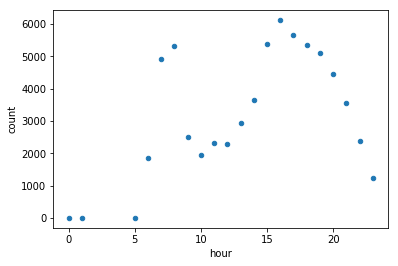

In [24]:
pdf[pdf.day == 'Tue'].plot.scatter('hour', 'count')

In [25]:
import matplotlib.pyplot as plt

(5.5, 23.5)

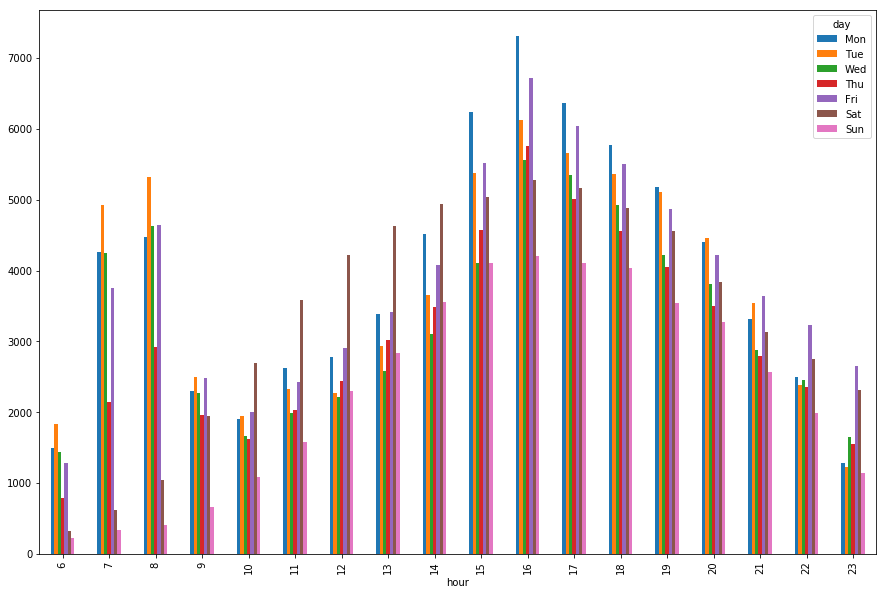

In [26]:
(pdf.pivot_table(columns='day', index='hour', values='count')
 [[calendar.day_abbr[i] for i in range(7)]]
 .plot.bar(figsize=(15,10)))
plt.xlim(5.5,23.5)

In [28]:
sc.stop()